In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, InputLayer, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

# prepare data

In [ ]:
raw_data = pickle.load(open(root+'raw_data_0604', 'rb'))

In [ ]:
vocab_size = 10000
input_dim = vocab_size + 2 # one for padding, one for oov token

## normal embeddings

In [ ]:
data = pickle.load(open(root+'preprocessed_data_0604', 'rb'))

In [ ]:
maxlen = int(data['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data['X_train_par'].str.split().str.len().quantile(0.9))

In [ ]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data['X_train'])

In [ ]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(data['X_train_par'])

## twitter embeddings

In [ ]:
data_tw = pickle.load(open(root+'preprocessed_data_twitter_0604', 'rb'))

In [ ]:
maxlen = int(data_tw['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data_tw['X_train_par'].str.split().str.len().quantile(0.9))

In [ ]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data_tw['X_train'])

In [ ]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(data_tw['X_train_par'])

## common crawl embeddings

In [ ]:
data_cc = pickle.load(open(root+'preprocessed_data_crawl_0604', 'rb'))

In [ ]:
maxlen = int(data_cc['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data_cc['X_train_par'].str.split().str.len().quantile(0.9))

In [ ]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data_cc['X_train'])

In [ ]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(data_cc['X_train_par'])

# no context
07.04.2022

In [ ]:
def build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix, reg=5e-6):
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        tokenizer_layer,
        Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[emb_matrix], trainable=True,
                embeddings_regularizer=L1L2(l1=reg, l2=reg)),

        Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2, padding='same'),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        MaxPooling1D(3, padding='same'),
        Dropout(0.3),

        Flatten(),
        Dense(100, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

## 100d normal embeddings

In [ ]:
vec_len = 100
emb_matrix_comment = WordEmbeddings().get_glove_embeddings(input_dim, vec_len,
                                                           tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


In [ ]:
model = build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix_comment, reg=5e-6)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 150s 23ms/step - loss: 1.6093 - accuracy: 0.6931 - val_loss: 0.7598 - val_accuracy: 0.7222
Epoch 2/50
6002/6002 [==============================] - 135s 23ms/step - loss: 0.6825 - accuracy: 0.7262 - val_loss: 0.6313 - val_accuracy: 0.7298
Epoch 3/50
6002/6002 [==============================] - 135s 23ms/step - loss: 0.6181 - accuracy: 0.7335 - val_loss: 0.6027 - val_accuracy: 0.7354
Epoch 4/50
6002/6002 [==============================] - 133s 22ms/step - loss: 0.5966 - accuracy: 0.7379 - val_loss: 0.5861 - val_accuracy: 0.7381
Epoch 5/50
6002/6002 [==============================] - 133s 22ms/step - loss: 0.5858 - accuracy: 0.7412 - val_loss: 0.5800 - val_accuracy: 0.7403
Epoch 6/50
6002/6002 [==============================] - 133s 22ms/step - loss: 0.5796 - accuracy: 0.7438 - val_loss: 0.5776 - val_accuracy: 0.7412
Epoch 7/50
6002/6002 [==============================] - 136s 23ms/step - loss: 0.5760 - accuracy: 0.7462 - val_loss: 0

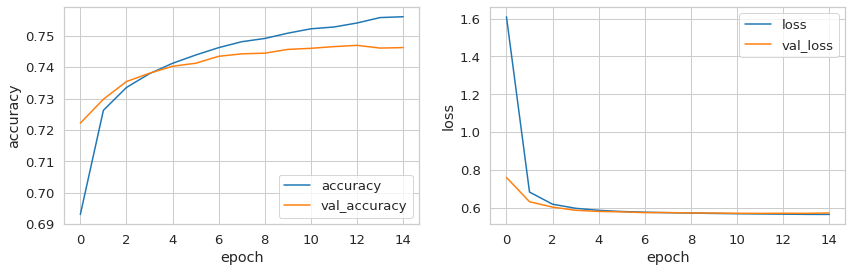

In [ ]:
plot_history(fit)

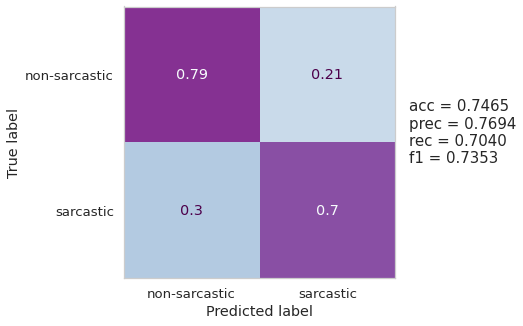

In [ ]:
evaluate(model, data['X_val'], data['y_val'])

In [ ]:
model.save(root+'models/cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn/assets


## 300d normal embeddings

In [ ]:
vec_len = 300
emb_matrix_comment = WordEmbeddings().get_glove_embeddings(input_dim, vec_len,
                                                           tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


In [ ]:
model = build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix_comment, reg=5e-6)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 142s 23ms/step - loss: 1.9094 - accuracy: 0.6964 - val_loss: 0.6973 - val_accuracy: 0.7228
Epoch 2/50
6002/6002 [==============================] - 143s 24ms/step - loss: 0.6522 - accuracy: 0.7248 - val_loss: 0.6167 - val_accuracy: 0.7330
Epoch 3/50
6002/6002 [==============================] - 139s 23ms/step - loss: 0.6170 - accuracy: 0.7318 - val_loss: 0.6056 - val_accuracy: 0.7362
Epoch 4/50
6002/6002 [==============================] - 140s 23ms/step - loss: 0.6064 - accuracy: 0.7361 - val_loss: 0.5970 - val_accuracy: 0.7396
Epoch 5/50
6002/6002 [==============================] - 137s 23ms/step - loss: 0.6005 - accuracy: 0.7396 - val_loss: 0.5912 - val_accuracy: 0.7410
Epoch 6/50
6002/6002 [==============================] - 139s 23ms/step - loss: 0.5948 - accuracy: 0.7423 - val_loss: 0.5884 - val_accuracy: 0.7425
Epoch 7/50
6002/6002 [==============================] - 140s 23ms/step - loss: 0.5900 - accuracy: 0.7444 - val_loss: 0

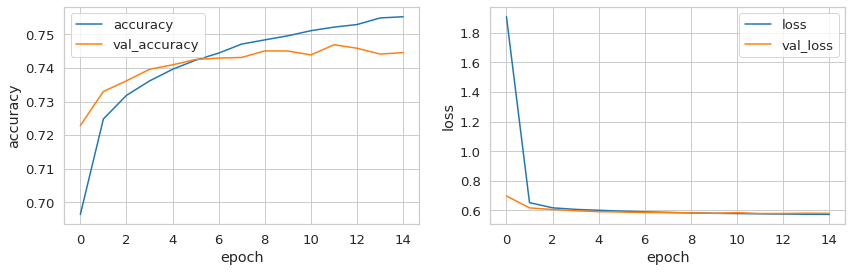

In [ ]:
plot_history(fit)

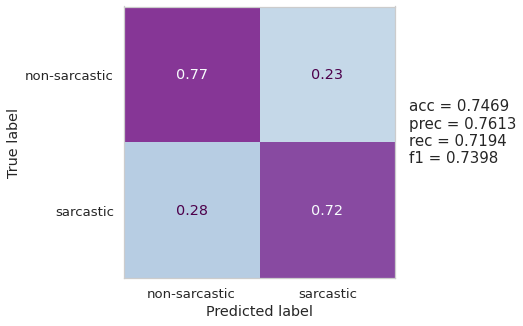

In [ ]:
evaluate(model, data['X_val'], data['y_val'])

In [ ]:
model.save(root+'models/cnn_300d')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_300d/assets


## twitter embeddings

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(),
                                                  emb_type='twitter', root=root)

coverage: 0.9941


In [ ]:
model = build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix_comment, reg=5e-6)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data_tw['X_train'], data_tw['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data_tw['X_val'], data_tw['y_val']))

Epoch 1/50
6002/6002 [==============================] - 158s 24ms/step - loss: 1.6339 - accuracy: 0.6958 - val_loss: 0.7603 - val_accuracy: 0.7216
Epoch 2/50
6002/6002 [==============================] - 145s 24ms/step - loss: 0.6784 - accuracy: 0.7279 - val_loss: 0.6291 - val_accuracy: 0.7332
Epoch 3/50
6002/6002 [==============================] - 145s 24ms/step - loss: 0.6163 - accuracy: 0.7348 - val_loss: 0.5990 - val_accuracy: 0.7371
Epoch 4/50
6002/6002 [==============================] - 138s 23ms/step - loss: 0.5957 - accuracy: 0.7391 - val_loss: 0.5848 - val_accuracy: 0.7413
Epoch 5/50
6002/6002 [==============================] - 139s 23ms/step - loss: 0.5861 - accuracy: 0.7419 - val_loss: 0.5803 - val_accuracy: 0.7418
Epoch 6/50
6002/6002 [==============================] - 145s 24ms/step - loss: 0.5806 - accuracy: 0.7437 - val_loss: 0.5795 - val_accuracy: 0.7409
Epoch 7/50
6002/6002 [==============================] - 145s 24ms/step - loss: 0.5774 - accuracy: 0.7459 - val_loss: 0

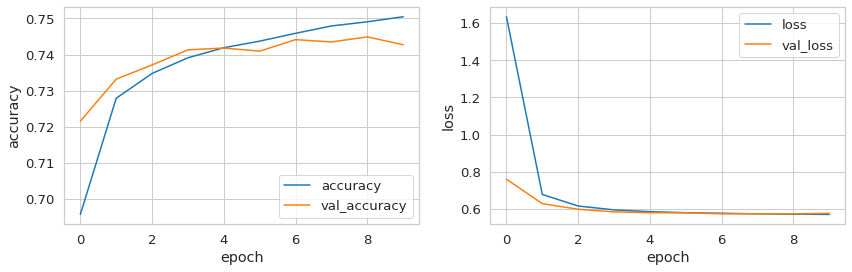

In [ ]:
plot_history(fit)

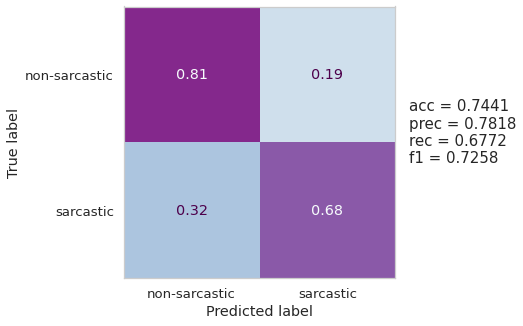

In [ ]:
evaluate(model, data_tw['X_val'], data_tw['y_val'])

In [ ]:
model.save(root+'models/cnn_twitter_emb')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_twitter_emb/assets


## common crawl embeddings

In [ ]:
vec_len = 300
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(),
                                                  emb_type='crawl_uncased', root=root)

coverage: 0.9954


In [ ]:
model = build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix_comment, reg=5e-6)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data_cc['X_train'], data_cc['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data_cc['X_val'], data_cc['y_val']))

Epoch 1/50
6002/6002 [==============================] - 174s 27ms/step - loss: 2.0125 - accuracy: 0.6978 - val_loss: 0.7493 - val_accuracy: 0.7240
Epoch 2/50
6002/6002 [==============================] - 156s 26ms/step - loss: 0.6821 - accuracy: 0.7247 - val_loss: 0.6357 - val_accuracy: 0.7266
Epoch 3/50
6002/6002 [==============================] - 158s 26ms/step - loss: 0.6254 - accuracy: 0.7318 - val_loss: 0.6140 - val_accuracy: 0.7336
Epoch 4/50
6002/6002 [==============================] - 158s 26ms/step - loss: 0.6118 - accuracy: 0.7356 - val_loss: 0.6046 - val_accuracy: 0.7364
Epoch 5/50
6002/6002 [==============================] - 152s 25ms/step - loss: 0.6042 - accuracy: 0.7387 - val_loss: 0.5947 - val_accuracy: 0.7397
Epoch 6/50
6002/6002 [==============================] - 147s 25ms/step - loss: 0.5983 - accuracy: 0.7417 - val_loss: 0.5922 - val_accuracy: 0.7401
Epoch 7/50
6002/6002 [==============================] - 146s 24ms/step - loss: 0.5920 - accuracy: 0.7443 - val_loss: 0

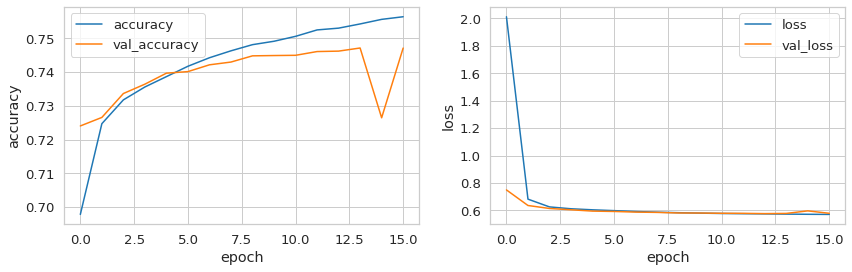

In [ ]:
plot_history(fit)

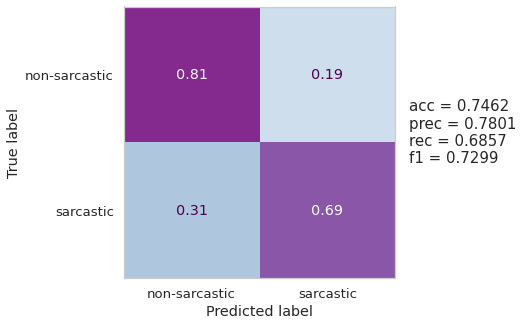

In [ ]:
evaluate(model, data_cc['X_val'], data_cc['y_val'])

In [ ]:
model.save(root+'models/cnn_cc_emb')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_cc_emb/assets


# context
11.04.2022

In [ ]:
vec_len = 100

wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_par_layer.get_vocabulary(), root=root)

coverage: 0.9813
coverage: 0.9888


In [ ]:
train_data = {'comment': data['X_train'], 'parent': data['X_train_par']}
val_data = {'comment': data['X_val'], 'parent': data['X_val_par']}

In [ ]:
def build_cnn(tok_layer, vec_len, maxlen, embedding_matrix, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)

    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalMaxPooling1D()(x)

    return x

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_cnn = build_cnn(tokenize_comment, vec_len, maxlen, emb_matrix_comment, reg=5e-6)
parent_cnn = build_cnn(tokenize_parent, vec_len, maxlen_par, emb_matrix_parent, reg=5e-6)

x = Concatenate()([comment_cnn, parent_cnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 242s 38ms/step - loss: 2.3349 - accuracy: 0.6981 - val_loss: 0.7727 - val_accuracy: 0.7210
Epoch 2/50
6002/6002 [==============================] - 232s 39ms/step - loss: 0.6801 - accuracy: 0.7298 - val_loss: 0.6284 - val_accuracy: 0.7355
Epoch 3/50
6002/6002 [==============================] - 225s 38ms/step - loss: 0.6173 - accuracy: 0.7369 - val_loss: 0.6042 - val_accuracy: 0.7357
Epoch 4/50
6002/6002 [==============================] - 225s 38ms/step - loss: 0.5968 - accuracy: 0.7419 - val_loss: 0.5885 - val_accuracy: 0.7432
Epoch 5/50
6002/6002 [==============================] - 224s 37ms/step - loss: 0.5859 - accuracy: 0.7471 - val_loss: 0.5852 - val_accuracy: 0.7428
Epoch 6/50
6002/6002 [==============================] - 226s 38ms/step - loss: 0.5789 - accuracy: 0.7504 - val_loss: 0.5772 - val_accuracy: 0.7460
Epoch 7/50
6002/6002 [==============================] - 226s 38ms/step - loss: 0.5748 - accuracy: 0.7524 - val_loss: 0

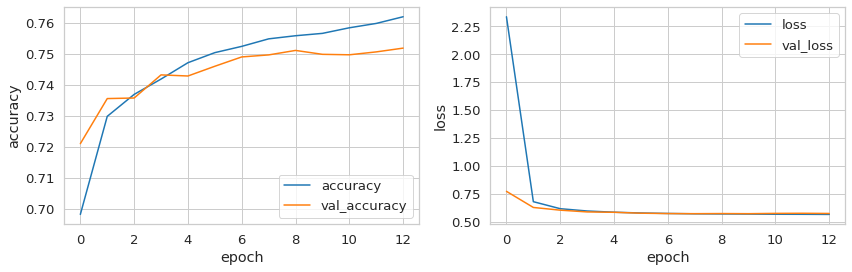

In [ ]:
plot_history(fit)

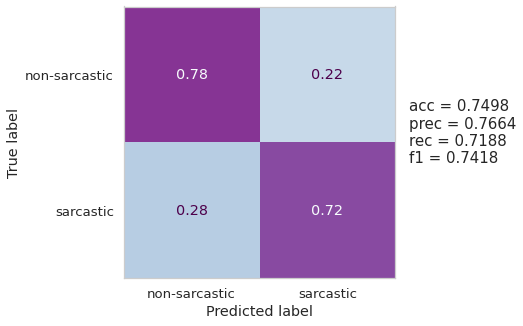

In [ ]:
evaluate(model, (data['X_val'], data['X_val_par']), data['y_val'])

In [ ]:
show_errors(model, raw_data['X_val'].values, (data['X_val'], data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Yeah, I think we're going to see Deathstroke fighting Batman in Justice League
comment: Anyone for a tank battle?

parent: 50 % off on Logitech Trackman Marble Mouse, Four-Button, Programmable, Dark Gray - $ 14.99
comment: Recommend this for competitive gaming.

parent: Those are ducklings That's also a capybara not a Guinea pig Unless of course your on New Guinea?
comment: That's "you're".

parent: What is the creepiest enemy in the game? I would have to either go with the guys that open up the flaps in their chest and shoot a laser, or the guys that look just like isaac but have bloody eyes.
comment: Pestilence, the goo gets everywhere

parent: By far the coolest way to mount a static display plane!
comment: Yeah but that's an F4 so its probably the only time that aircraft has appeared to clime at that steep an angle.


False positives:
---------------------------
parent: Metalhead guitarist problems
comment: Pffft, just tune your 

In [ ]:
model.save(root+'models/context_cnn_globalmaxpool')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_cnn_globalmaxpool/assets
